In [18]:
from IPython.display import Image

# The Plan

## Phase 1 
#### _21.12.2020 - 21.02.2021_
1. Explore existing literature on hyperbolic deep learning on graphs (HGCN, HGNN papers)
2. Understand the basic concepts of Diffential Geometry 
3. Understand the code structure of existing solutions 
4. Implement the hyperbolic graph convolution layer in PyTorch Geometric 
$$\textit{you are here}$$
5. Implement Hyperbolic Deep Graph Matching Consensus (and make it work)
6. Test the performance on the DBP15k dataset

## Phase 2
#### _21.02 - ???_
1. Research existing datasets for graph matching and find out suitable geometry for each
2. Implement Spherical Deep Graph Matching Consensus (boils down to implementing the Spherical manifold)
3. Test the performance of the three versions of DGMC (Eucl., Hyp., Sph.) on these datasets
4. ?????

# The Diary

## _17.02_
* Q: Are the weights in the hyperbolic layer Euclidian or Hyperbolic, in which way should they be optimized? $\\$
A: The weights operate in the tangent space, hence they are Euclidian $\\$
* P: Implementing a layer with $in\_channels \neq out\_channels$ $\\$
S: To rewrite _aggregate_, _message_ and _update_ methods $\\$
* I have run the HDGMC algorithm on the DBP15k dataset, the results are below

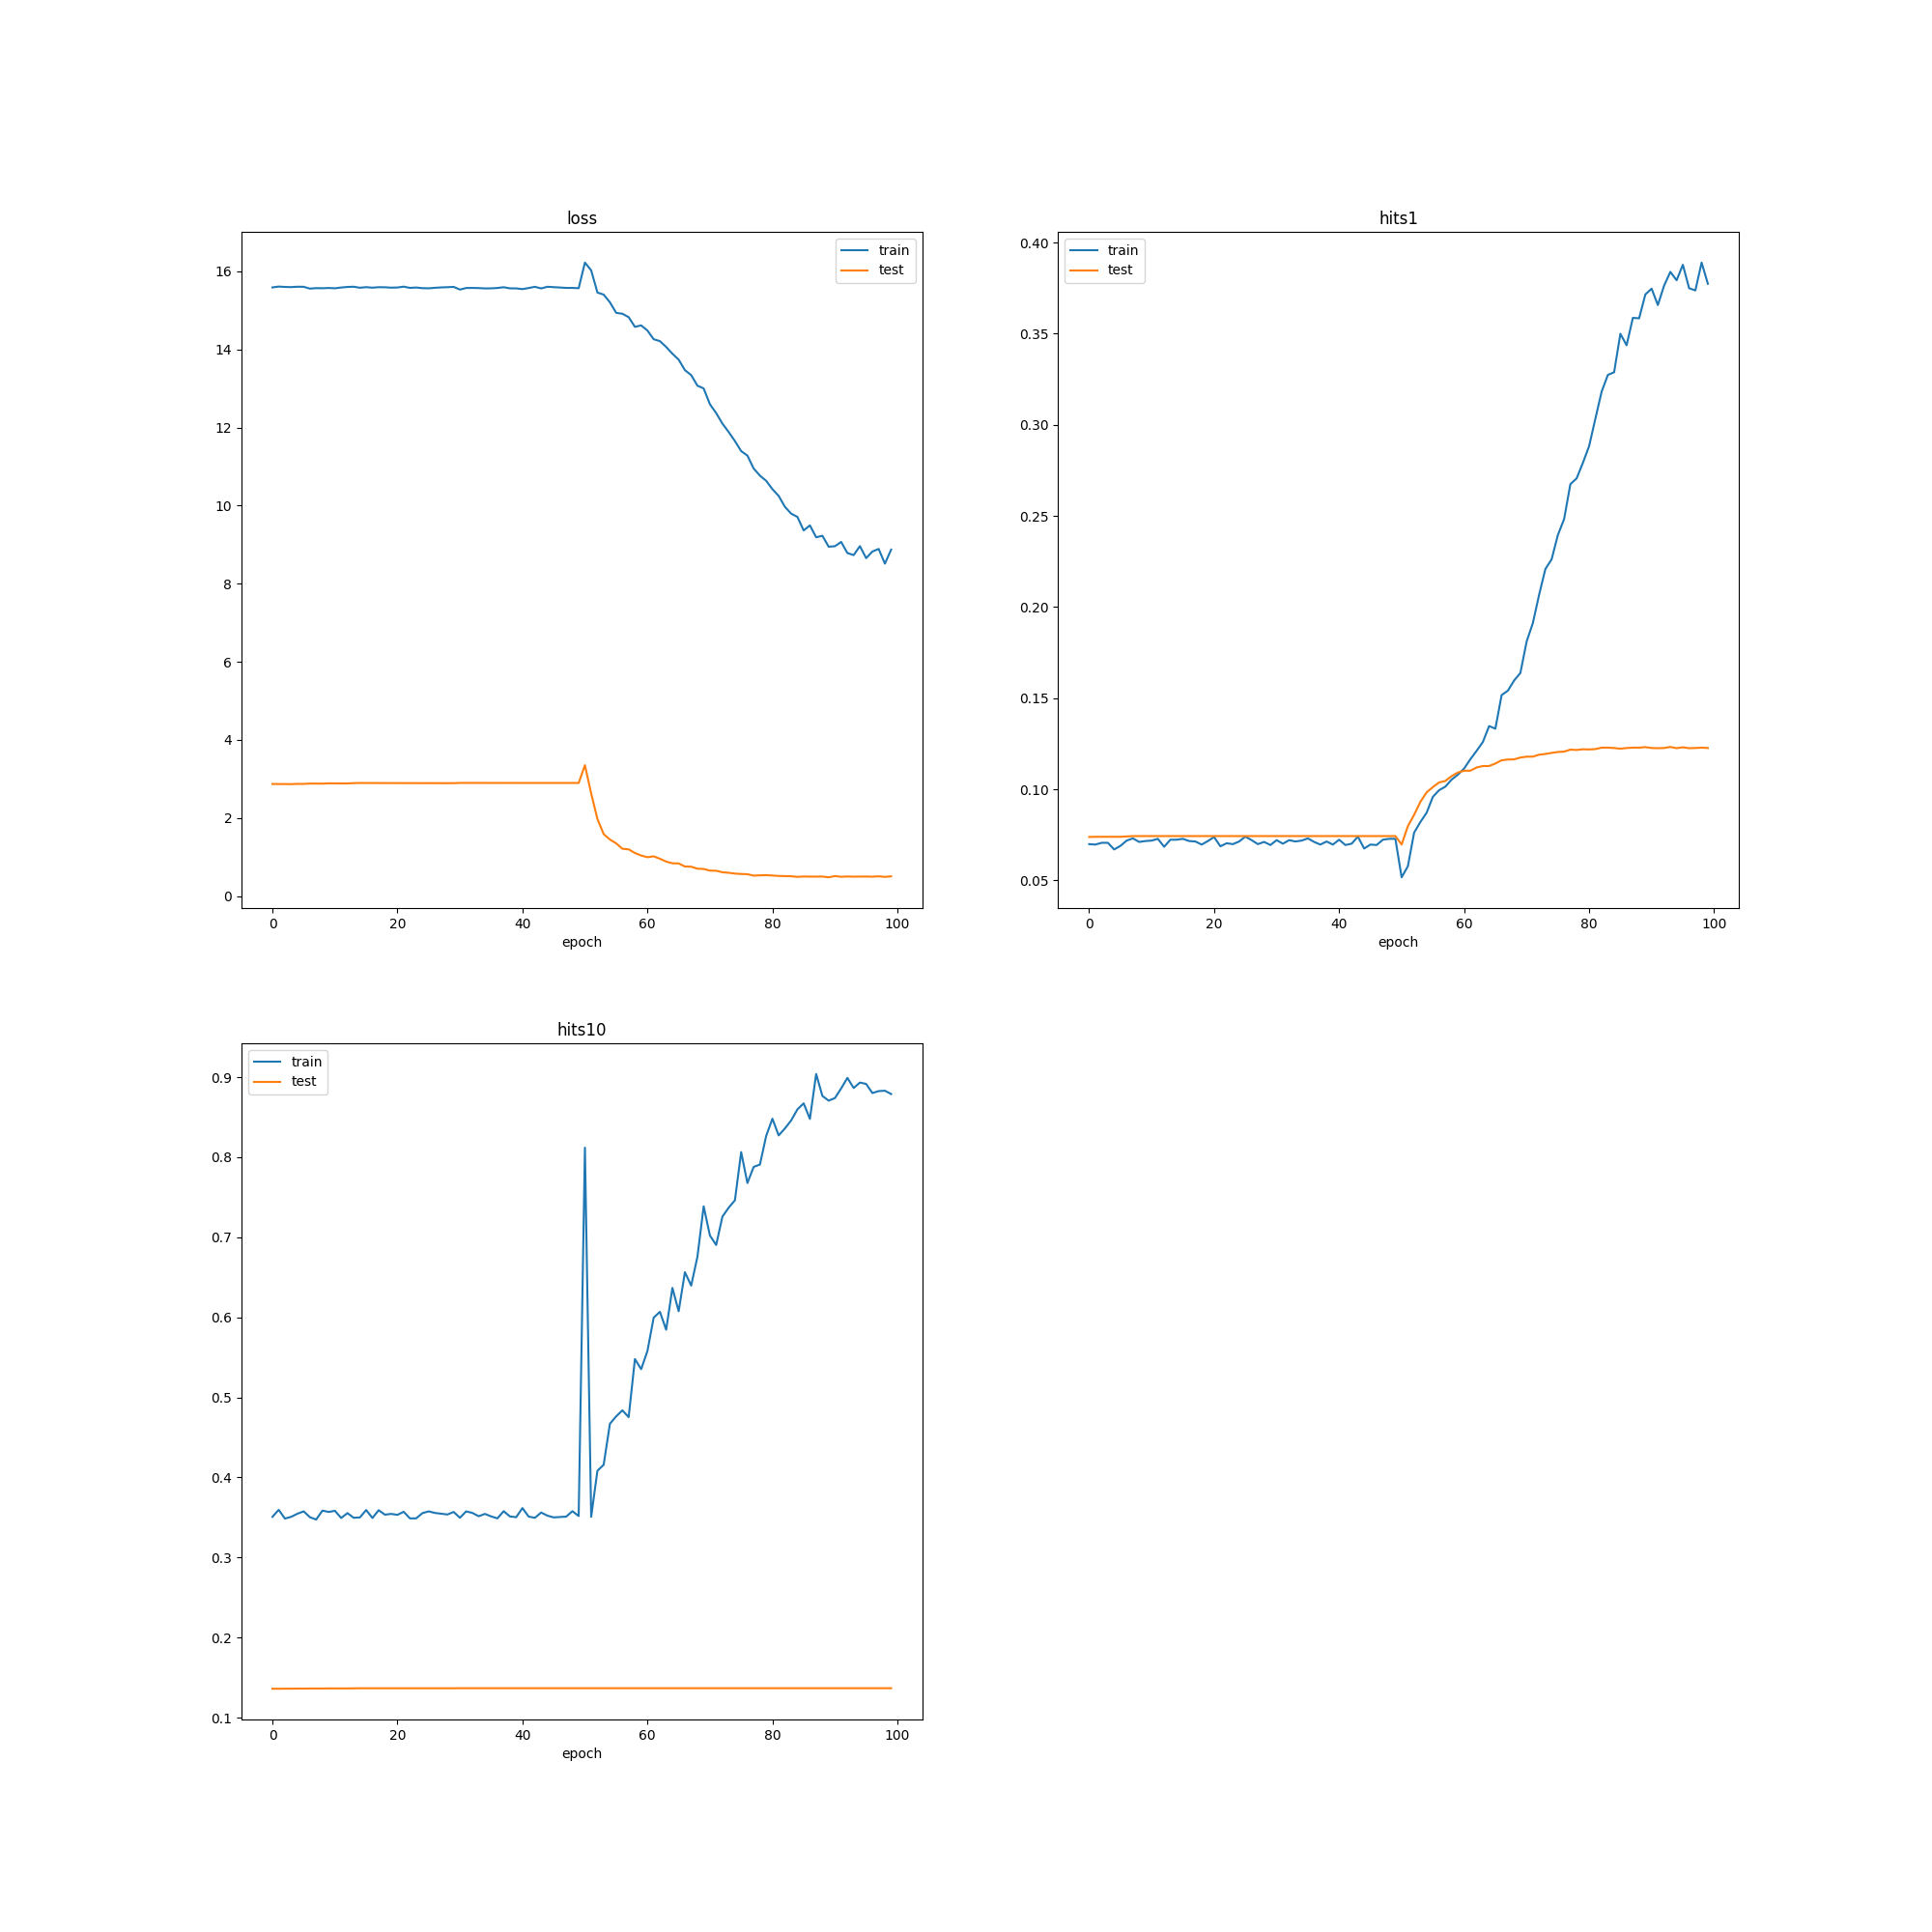

In [25]:
Image('results_first_run.png')

* This is weird. Need to check the code for errors.
* Q: Why is there _better than random_ performance even after the first epoch? $\hfill\newline$
A: ... $\hfill\newline$

* Q: Why does the improvement start only in the neighborhood consensus stage? $\hfill\newline$
H: Most of the embeddings are zero as a result of ReLU (no) $\hfill\newline$
H: Maybe the initial similarity matrix calculation is incorrect? (i think it is correct) $\hfill\newline$
N: Check if the embeddings remain on the hyperboloid. (no, they do not, see _18.02_ entry) $\hfill\newline$
A: ...

## _18.02_
* I have found out that for vectors with high Euclidian norm, _expmap0_ method blows up and the result is not on the hyperboloid due to numerical reasons. At least its squared Minkowski norm is not equal to $-\frac{1}{K}$ as it should be. Maybe this is a result of the substraction of two big floating point numbers in _minkowski_dot_.
* Below are the plots which show for which norm the squared Minkowski norm starts going crazy for different numbers of dimensions and different curvatures.
* The first group of plots shows the dependence of the critical norm on the number of dimensions with fixed curvature, and the second group of plots is vice versa.

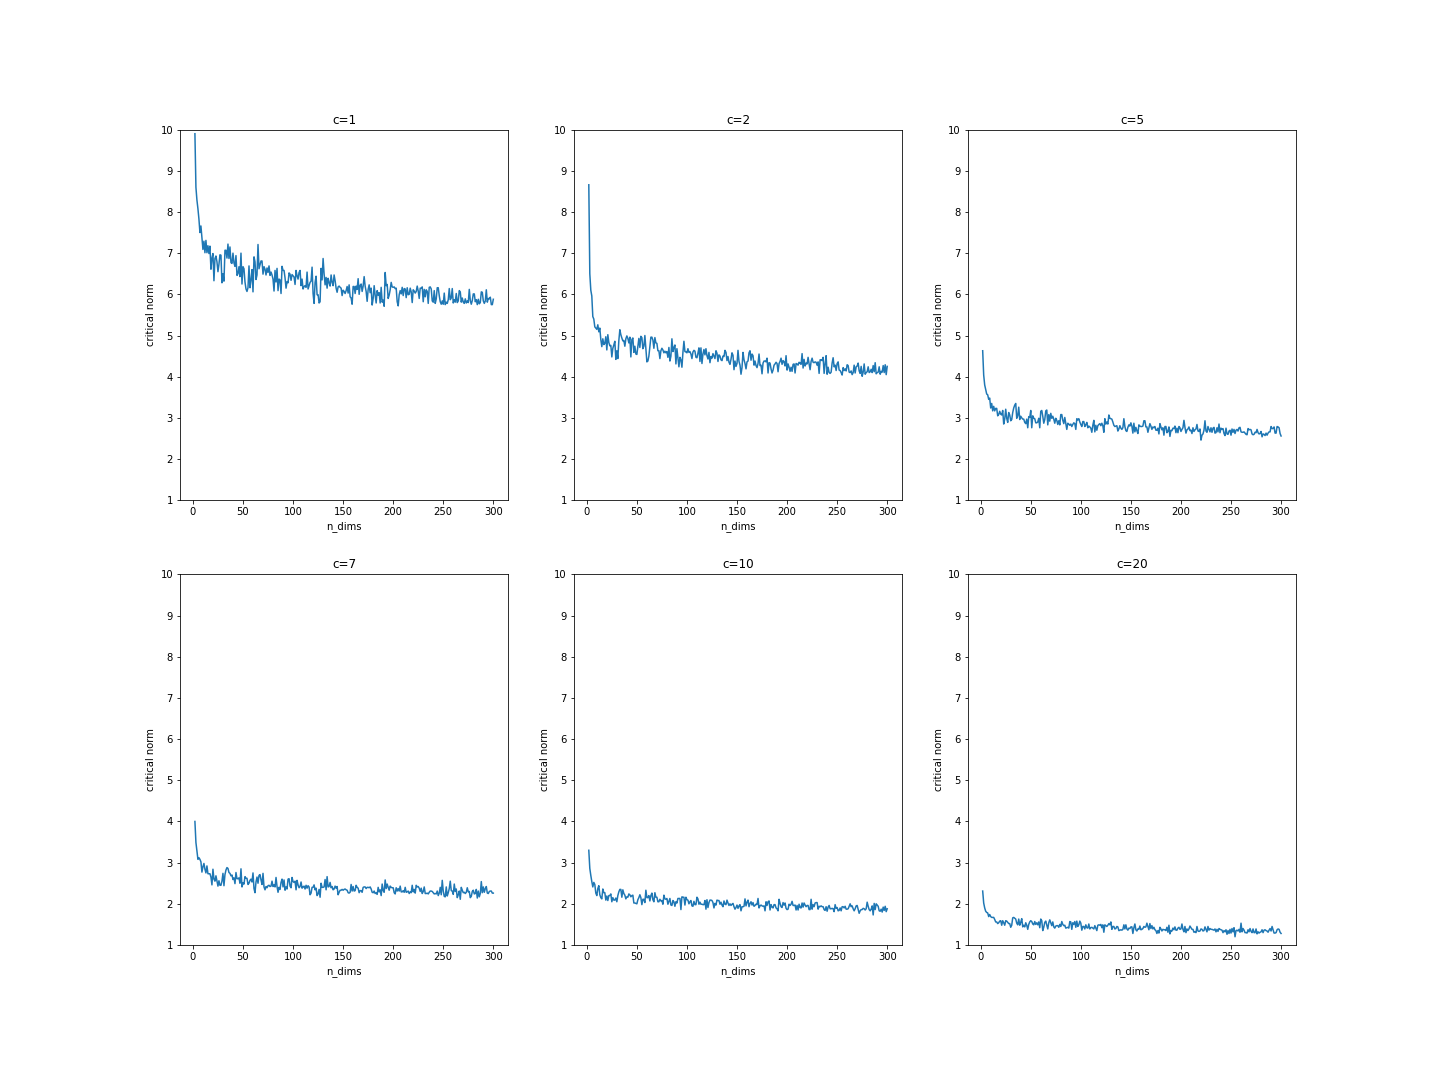

In [29]:
Image('critical_norm1.png')

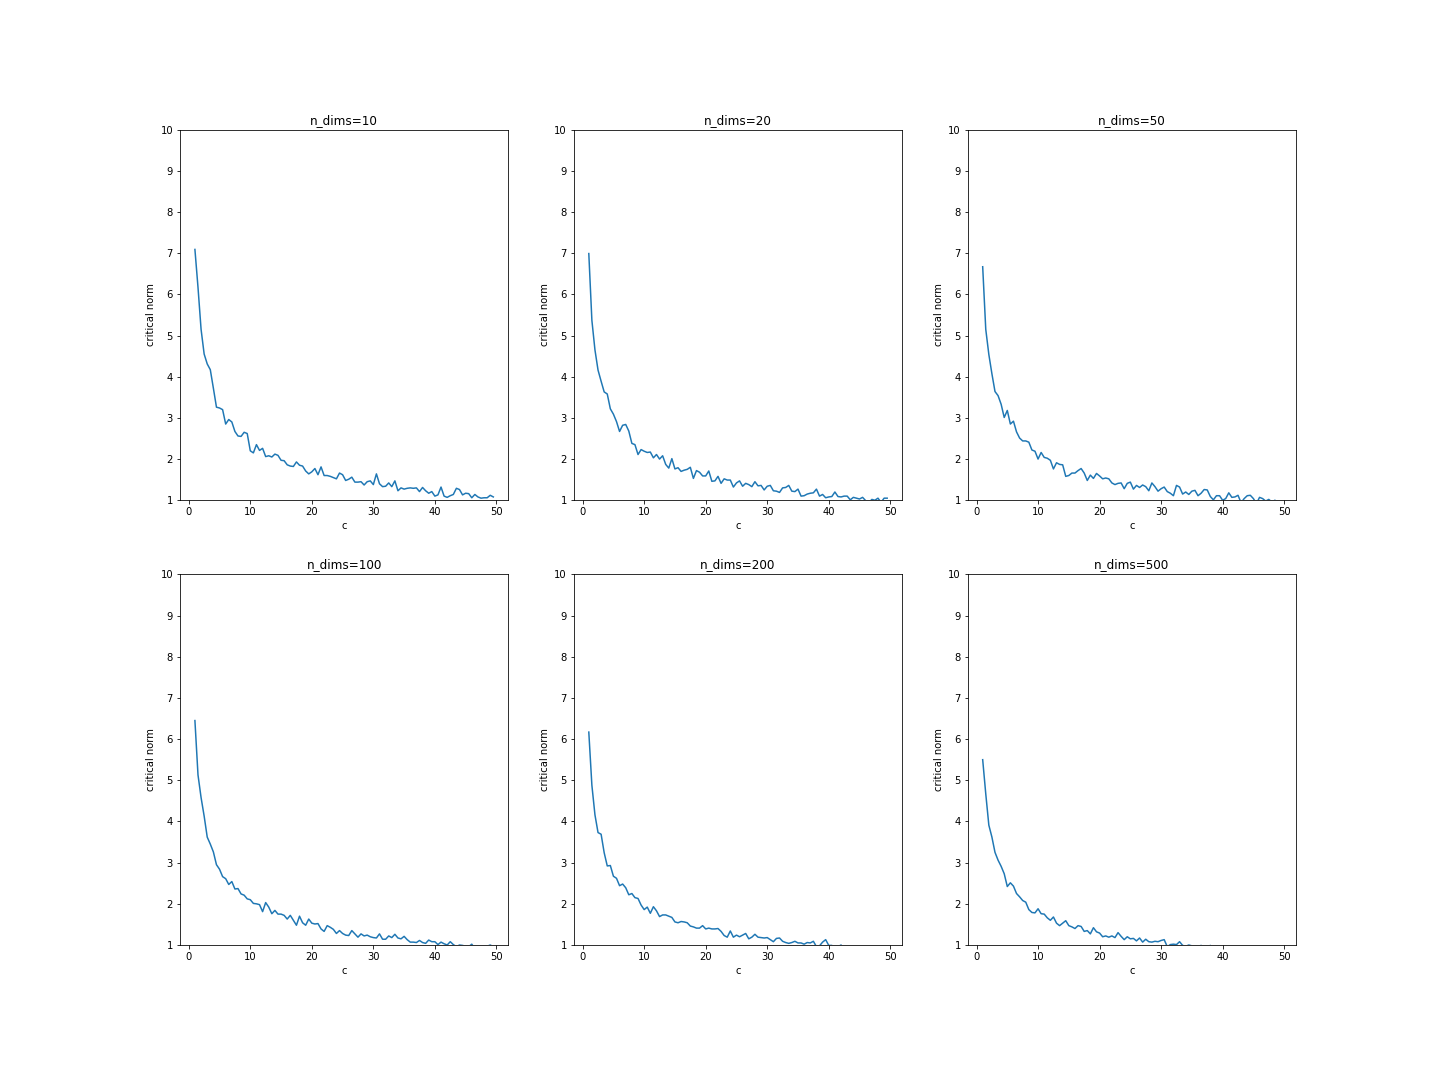

In [30]:
Image('critical_norm2.png')

## _19.02_

* Made a conclusion about the above graphs that the critical norm depends only on the curvature, not the number of dimensions, which is kinda intuitive
* Found out that if the initial embeddings are divided by $5$, their _expmap0_ does not explode and they end up on the hyperboloid after _expmap0_
* P: However, after passing them through the network, they are not on the hyperboloid. Tried lowering the norm of the weights in the network, it didn't work, tried changing the aggregation procedure from _sum_ to _mean_, didn't work also. I have suspicions that the repeated applications of _expmap_ cause this. $\\$
S: The problem was that through DGMC, the outputs of different layers are concatenated, this crashes the hyperbolic procedure $\\$
* __IMPORTANT:__ If I calculate _hits1_ by just applying _expmap0_ to the initial embeddings and then calculating the similarity via Minkowski scalar product, I get $0.55$ _hits1_. This indicates that the network does not work (at least its first stage). After the second stage train _hits1_ go up to $0.4$.


## _23.02_
* Tried checking if the embeddings stay on the hyperboloid through the forward pass in the experiments from the paper (yes, they do)
* Q: Why they do using the data from the paper and don't using the DBP15k dataset
* The main problem at the moment is that the gradient vanishes

## _28.02_

* Tried inserting backward hooks everywhere< found out that at some point the gradient norm drops by $8$ orders of magnitude. The reason for this is unknown yet.
* The training dynamics in the paper's authors' experiments is kinda weird, needs some investigation.
* I got suspicious that in the authors' experiments the performance is gained only due to the training of the linear Euclidean decoder, checked the norms of gradients for both Hyperbolic encoder and Euclidean decoder: they are comparable, a proof of concept of sorts.
* I think some experiments on toy synthetic data should be done for a clearer view of where the problem might be.

## _02.03_
* The training dynamics turned out to de strange due to low train size ($60$ nodes)
* Came up with another idea: instead of computing similarity via Minkowski dot, apply $proj\_tan0 \circ logmap0$ to the embeddings and then compute Euclidean similarity
* Found out a critical error in the similarity matrix computation, fixed it, the model does not train still :(
* Finally figured out what was wrong!

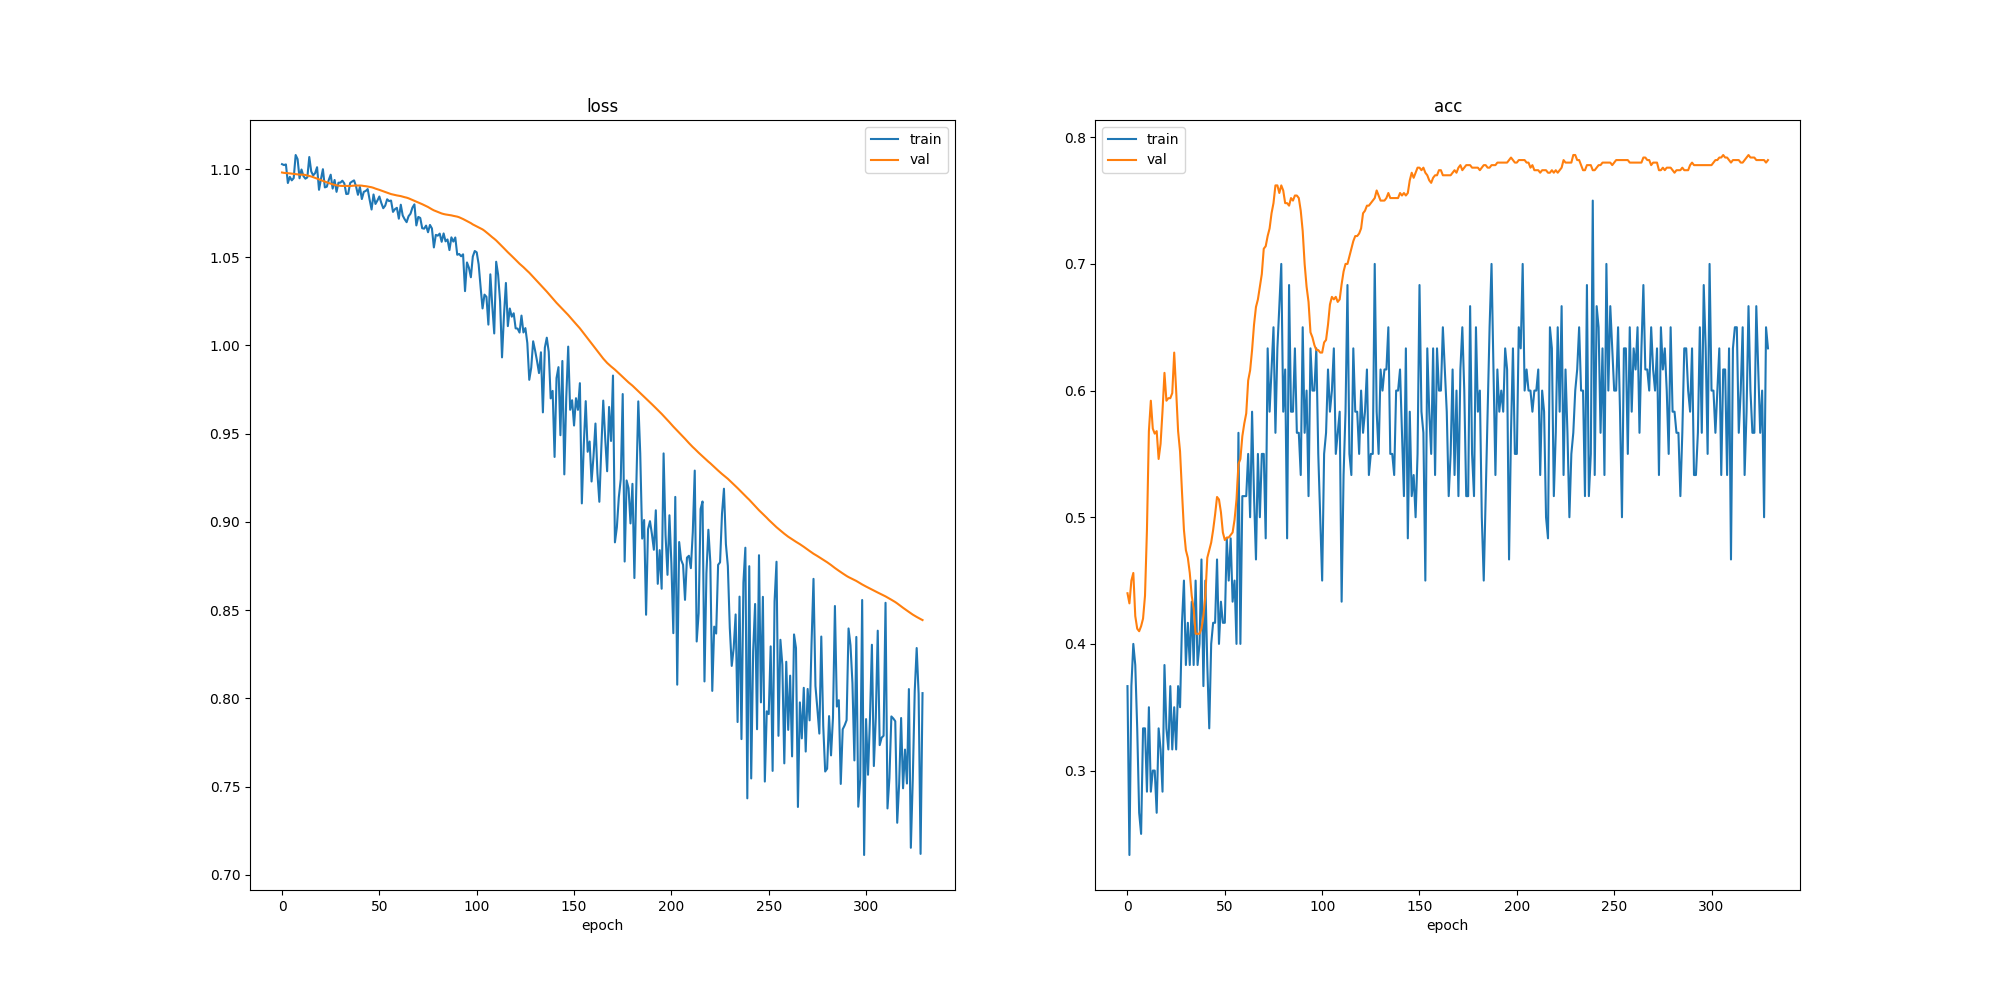

In [31]:
# this is HGCN
Image('strange_hgcn_dynamicsHGCN.png')

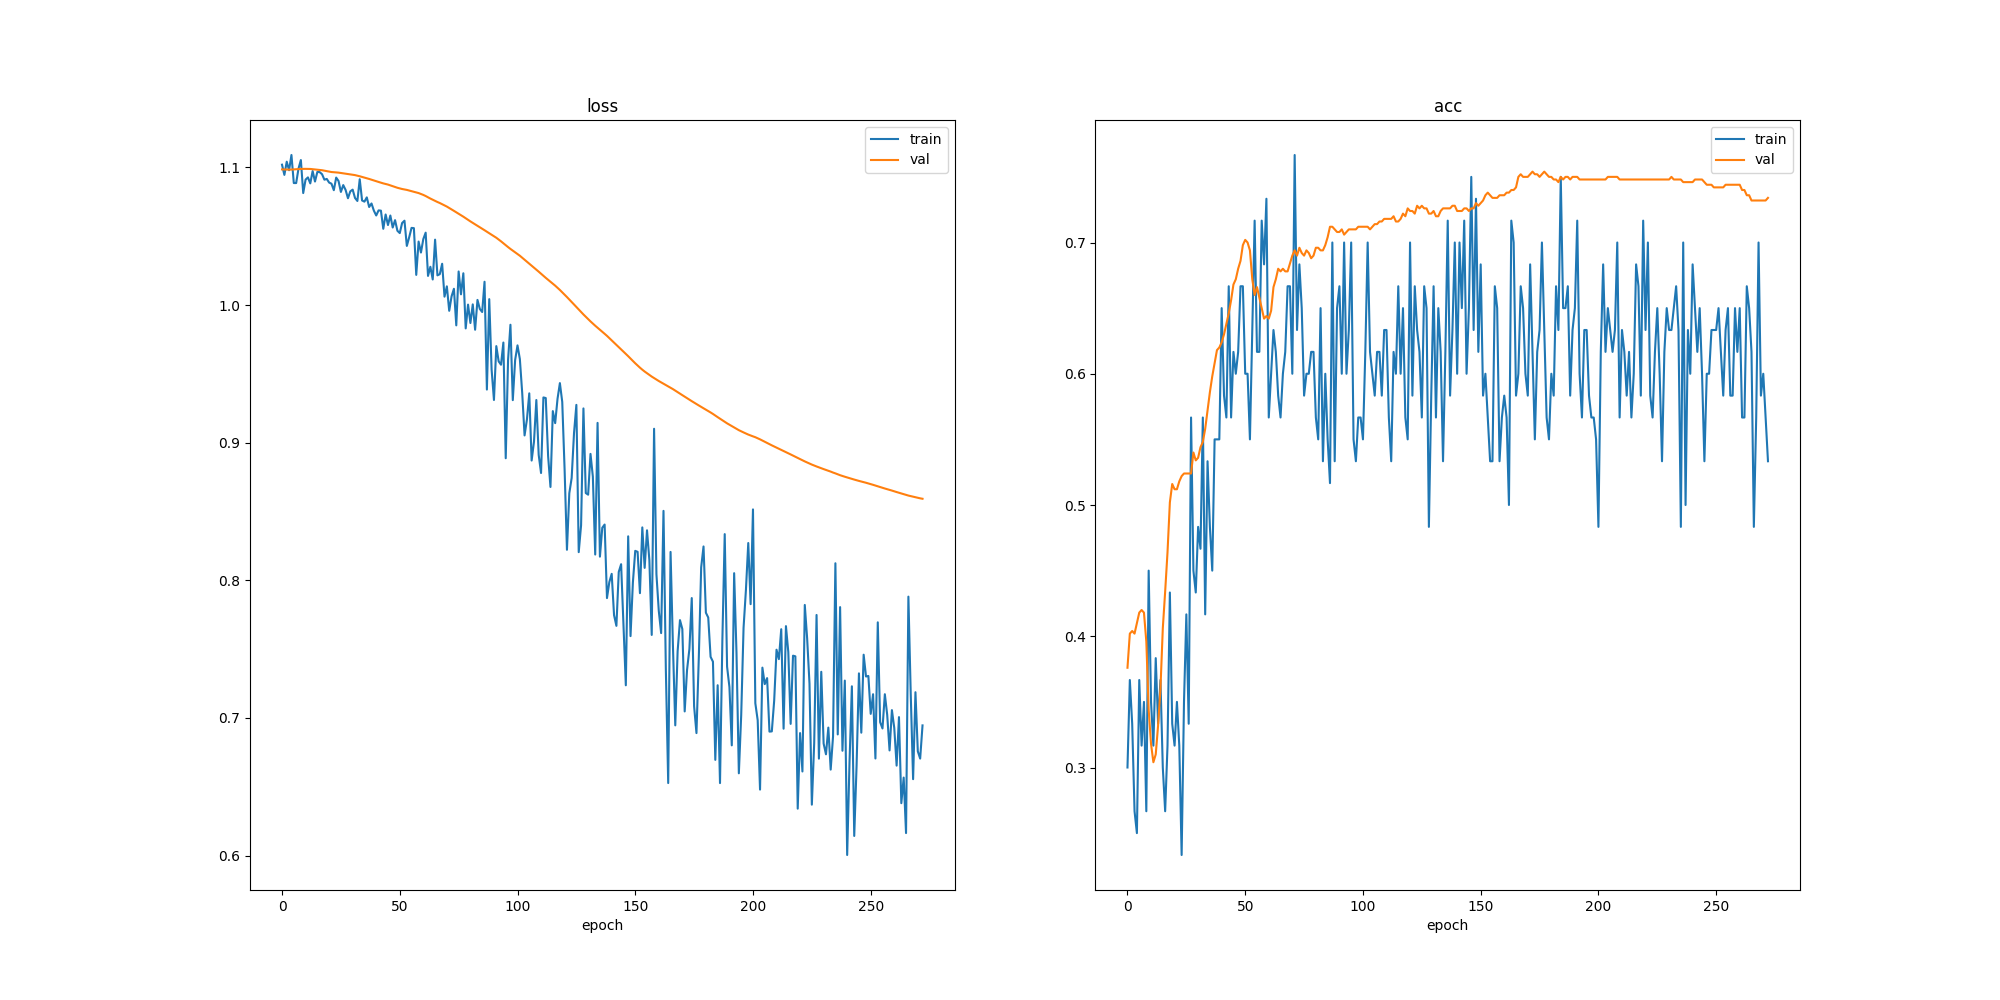

In [32]:
# this is HGCN
Image('strange_hgcn_dynamicsMyHGCN.png')

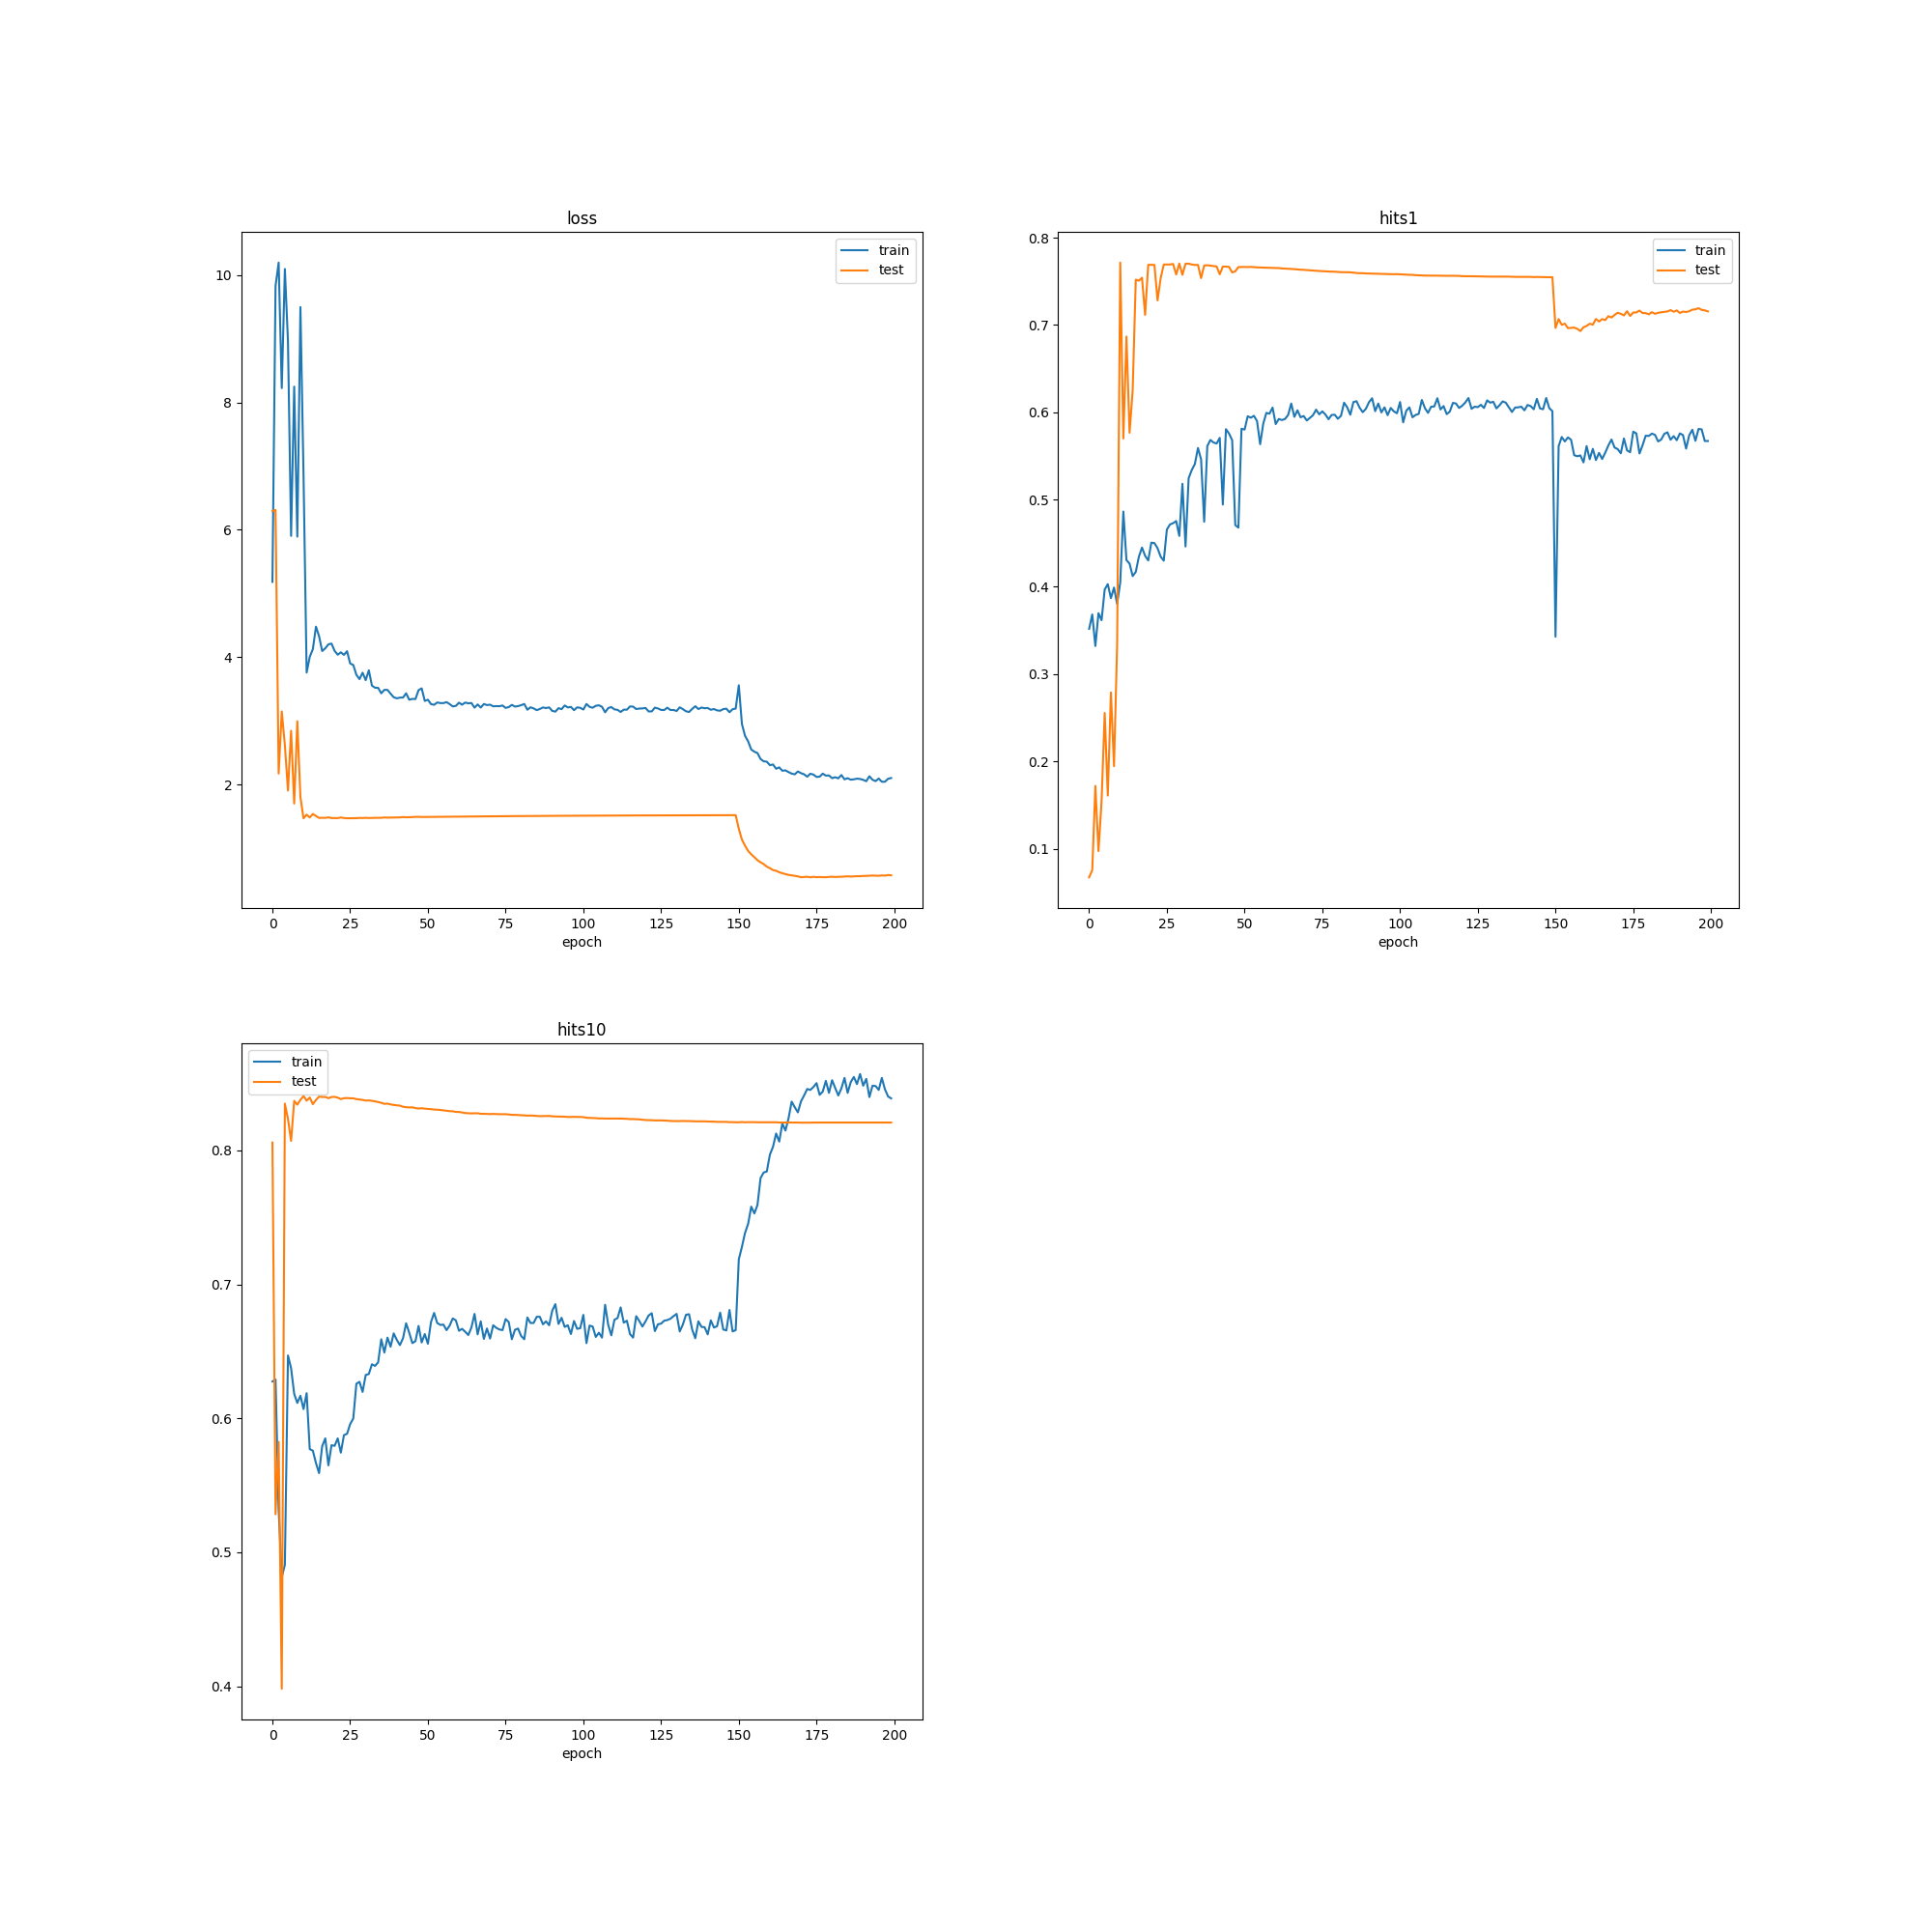

In [33]:
# this is HDGMC
Image('results_initial_ver0.png')